In [55]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

### Información: 

En esta prueba de concepto, se serializará un análisis predictivo, con el objetivo de predecir la probabilidad de predecir lesiones de jugadores del futbol.

Para esta prueba se han tomado los datos de un repositorio de github -> https://github.com/swathikiran86/Sports-Injury-Analysis. Teniendo un conjunto de 3 datasets, los cuales fueron unidos para conformar uno solo, estos teniendo datos del atleta, fechas de lesión y otras informaciones complementarias al momento de producirse las lesiones. 

Para poner en práctica de este experimento, hemos filtrado los campeonatos de LaLiga, en los periodos del 2012 al 2021.

Se tomaron los eventos de cada uno de los partidos de las competiciones y filtramos por los eventos de tiros.

#### Modelos predictivos a utilizar:
- K-Nearest Neighbors (KNN)
- Regresión Logística
- Árbol de Decisiones
- Soporte de Vectores (SVM)

In [56]:
#Lectura de dataset
metrics = pd.read_csv("metrics.csv")
metrics

,athlete_id,date,metric,value
0,1,2016-05-01,hip_mobility,36
1,1,2016-05-02,hip_mobility,36
2,1,2016-05-03,hip_mobility,56
3,1,2016-05-04,hip_mobility,24
4,1,2016-05-05,hip_mobility,35
...,...,...,...,...
43795,30,2018-04-26,groin_squeeze,227
43796,30,2018-04-27,groin_squeeze,88
43797,30,2018-04-28,groin_squeeze,94
43798,30,2018-04-29,groin_squeeze,99


## Prepocesamiento

In [57]:
#Visualizamos los tipos de los datos
metrics.dtypes

athlete_id     int64
date          object
metric        object
value          int64
dtype: object

In [58]:
#Cambiamos a fecha la columna de fecha
metrics['date'] = metrics['date'].astype('datetime64[ns]')
metrics.dtypes

athlete_id             int64
date          datetime64[ns]
metric                object
value                  int64
dtype: object

In [59]:
#Lectura de dataset
workload = pd.read_csv("game_workload.csv")
workload

,athlete_id,date,game_workload
0,1,2016-05-05,402
1,1,2016-05-08,365
2,1,2016-05-11,457
3,1,2016-05-16,405
4,1,2016-05-20,407
...,...,...,...
2395,30,2018-02-27,414
2396,30,2018-03-08,471
2397,30,2018-04-08,440
2398,30,2018-04-11,371


In [60]:
#Visualizamos los tipos de los datos
metrics.dtypes

athlete_id             int64
date          datetime64[ns]
metric                object
value                  int64
dtype: object

In [61]:
#Cambiamos a fecha la columna de fecha
workload['date'] = workload['date'].astype('datetime64[ns]')
workload.dtypes

athlete_id                int64
date             datetime64[ns]
game_workload             int64
dtype: object

In [62]:
#Lectura de dataset
injuries = pd.read_csv("injuries.csv")
injuries

,athlete_id,date
0,1,2016-05-11
1,1,2016-05-16
2,1,2016-07-28
3,1,2016-11-11
4,1,2016-12-16
...,...,...
132,29,2018-03-30
133,29,2018-04-30
134,30,2016-05-28
135,30,2017-07-13


In [63]:
#Visualizamos los tipos de los datos
injuries.dtypes

athlete_id     int64
date          object
dtype: object

In [64]:
#Cambiamos a fecha la columna de fecha
injuries['date'] = injuries['date'].astype('datetime64[ns]')
injuries.dtypes

athlete_id             int64
date          datetime64[ns]
dtype: object

## Análisis Exploratorio

In [65]:
injury_counts = injuries.groupby("athlete_id").count().reset_index()
#.sort_values(by= ["date"],ascending=False)

injury_counts = injury_counts.rename(columns={'date':'total_injuries'})

In [66]:
injury_counts.sort_values("total_injuries", ascending = False,inplace= True)
injury_counts

,athlete_id,total_injuries
0,1,12
23,25,12
20,22,10
2,3,9
16,18,7
27,29,7
1,2,7
18,20,6
22,24,5
11,12,5


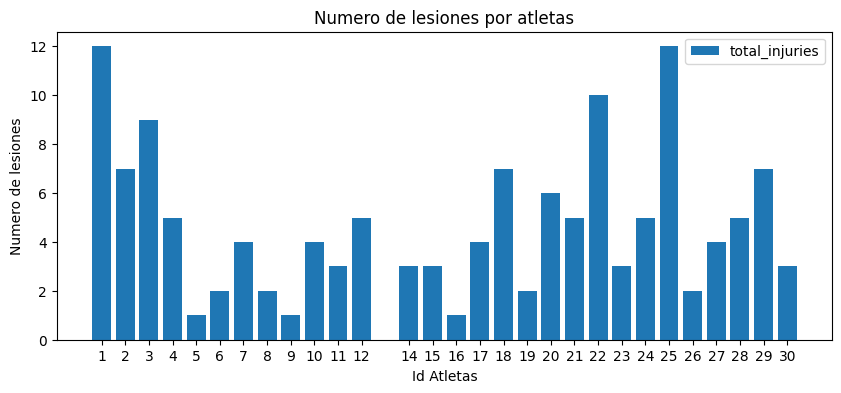

In [119]:
rcParams['figure.figsize'] = 10, 4
plt.bar(injury_counts["athlete_id"], injury_counts["total_injuries"])
plt.xticks(injury_counts["athlete_id"])
plt.legend(['total_injuries'])
plt.title("Numero de lesiones por atletas")
plt.xlabel('Id Atletas')
plt.ylabel('Numero de lesiones')
plt.show()

<Axes: title={'center': 'Average Workload by players'}, ylabel='athlete_id'>

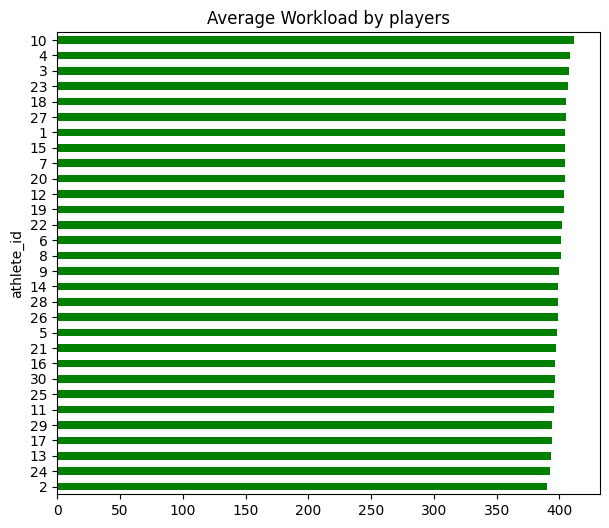

In [68]:

rcParams['figure.figsize'] =7, 6
workload.groupby("athlete_id")['game_workload'].mean().sort_values().plot(kind = 'barh',y= 'workload', x="athlete_id",
                     title = "Average Workload by players",color='g')

## PreProcesamiento

In [69]:
#Agregamos una columna nueva al dataset 
injuries["injury"] = "Yes"

In [70]:
injuries

,athlete_id,date,injury
0,1,2016-05-11,Yes
1,1,2016-05-16,Yes
2,1,2016-07-28,Yes
3,1,2016-11-11,Yes
4,1,2016-12-16,Yes
...,...,...,...
132,29,2018-03-30,Yes
133,29,2018-04-30,Yes
134,30,2016-05-28,Yes
135,30,2017-07-13,Yes


In [71]:
#Como tenemos los datos en dataframes distintos, haremos un merge de ellos
games_data = pd.merge(workload,injuries,  how='left', left_on=['athlete_id','date'], right_on = ['athlete_id','date'])

In [72]:
#En este dataframe cambiaremos en la columna 'injury', para cuando no que los dias donde no existan lesiones coloque no.
games_data["injury"].fillna("No", inplace = True)

In [73]:
games_data.head()

,athlete_id,date,game_workload,injury
0,1,2016-05-05,402,No
1,1,2016-05-08,365,No
2,1,2016-05-11,457,Yes
3,1,2016-05-16,405,Yes
4,1,2016-05-20,407,No


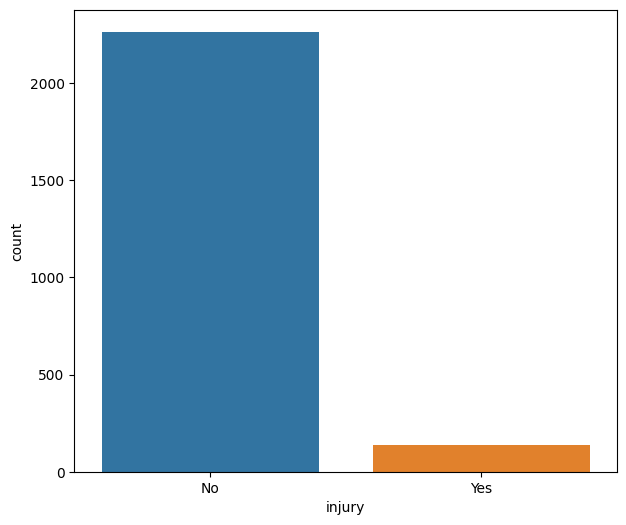

In [74]:
#Visualizamos como tenemos la ditribución de la variable objetivo 
sns.countplot(x='injury', data=games_data)

# Mostrar el gráfico
plt.show()

Vemos que el dataset se encuentra desbalanceado por lo que haremos un oversample.

In [75]:
#Como tenemos una columna para medir dos metricas diferentes para los dos tipos metrica 
new_metrics_df = metrics.pivot_table('value', ['athlete_id', 'date'], 'metric').reset_index()

In [76]:
new_metrics_df.head()

metric,athlete_id,date,groin_squeeze,hip_mobility
0,1,2016-05-01,297,36
1,1,2016-05-02,274,36
2,1,2016-05-03,291,56
3,1,2016-05-04,260,24
4,1,2016-05-05,284,35


In [77]:
#Por ultimo mergemos las las dos ultimos datset que hemos contruido para tener el dataset final 
final_data = pd.merge(games_data,new_metrics_df,  how='left', left_on=['athlete_id','date'], right_on = ['athlete_id','date'])


In [78]:
final_data.head()

,athlete_id,date,game_workload,injury,groin_squeeze,hip_mobility
0,1,2016-05-05,402,No,284,35
1,1,2016-05-08,365,No,250,41
2,1,2016-05-11,457,Yes,331,33
3,1,2016-05-16,405,Yes,260,38
4,1,2016-05-20,407,No,378,60


In [79]:
#Agregamos la columna "rest_period" para calcular los dias de descanso
final_data['rest_period'] = final_data.groupby('athlete_id')['date'].diff()

In [111]:
final_data.head()

,injury,athlete_id,date,game_workload,groin_squeeze,hip_mobility,rest_period
0,0,1,2016-05-05,402,284,35,4.0
1,0,1,2016-05-08,365,250,41,3.0
2,1,1,2016-05-11,457,331,33,3.0
3,1,1,2016-05-16,405,260,38,5.0
4,0,1,2016-05-20,407,378,60,4.0


In [112]:
#LLenamos los valores de REst_period que quedaron falando
first_day = '2016-05-01'
date_object = pd.to_datetime(first_day)

In [113]:
final_data["rest_period"].fillna(final_data['date'] - date_object, inplace = True)

In [114]:
final_data.head()

,injury,athlete_id,date,game_workload,groin_squeeze,hip_mobility,rest_period
0,0,1,2016-05-05,402,284,35,4.0
1,0,1,2016-05-08,365,250,41,3.0
2,1,1,2016-05-11,457,331,33,3.0
3,1,1,2016-05-16,405,260,38,5.0
4,0,1,2016-05-20,407,378,60,4.0


In [115]:
# Le damos formato a los dias de descanso 
final_data['rest_period'] = final_data['rest_period'].astype('timedelta64[D]')

In [116]:
final_data

,injury,athlete_id,date,game_workload,groin_squeeze,hip_mobility,rest_period
0,0,1,2016-05-05,402,284,35,4 days
1,0,1,2016-05-08,365,250,41,3 days
2,1,1,2016-05-11,457,331,33,3 days
3,1,1,2016-05-16,405,260,38,5 days
4,0,1,2016-05-20,407,378,60,4 days
...,...,...,...,...,...,...,...
2395,0,30,2018-02-27,414,31,41,5 days
2396,0,30,2018-03-08,471,-12,40,9 days
2397,0,30,2018-04-08,440,75,35,31 days
2398,0,30,2018-04-11,371,98,42,3 days


In [86]:
#Hacemos la matriz de correlación para ver donde donde existen relaciones
final_data.corr()

,athlete_id,game_workload,groin_squeeze,hip_mobility,rest_period
athlete_id,1.000000,-0.030159,-0.051175,-0.014437,-0.016292
game_workload,-0.030159,1.000000,-0.022571,0.000956,-0.023001
groin_squeeze,-0.051175,-0.022571,1.000000,-0.001996,0.039563
hip_mobility,-0.014437,0.000956,-0.001996,1.000000,0.006614
rest_period,-0.016292,-0.023001,0.039563,0.006614,1.000000


In [87]:
#Covertimos a binario nuuestra variable objetivo
final_data.injury.replace(to_replace=['No', 'Yes'], value=[0, 1], inplace = True)
final_data = final_data[['injury','athlete_id','date','game_workload','groin_squeeze','hip_mobility','rest_period']]

In [88]:
final_data.head()

,injury,athlete_id,date,game_workload,groin_squeeze,hip_mobility,rest_period
0,0,1,2016-05-05,402,284,35,4.0
1,0,1,2016-05-08,365,250,41,3.0
2,1,1,2016-05-11,457,331,33,3.0
3,1,1,2016-05-16,405,260,38,5.0
4,0,1,2016-05-20,407,378,60,4.0


In [89]:
#Creamos un dummy con la variable Athete_Id
dummy_variables = pd.get_dummies(final_data['athlete_id'])
ready_data = pd.concat([final_data,dummy_variables], axis=1)

In [90]:
ready_data.head()

,injury,athlete_id,date,game_workload,groin_squeeze,hip_mobility,rest_period,1,2,3,...,21,22,23,24,25,26,27,28,29,30
0,0,1,2016-05-05,402,284,35,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,2016-05-08,365,250,41,3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2016-05-11,457,331,33,3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2016-05-16,405,260,38,5.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,2016-05-20,407,378,60,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
ready_data.drop('athlete_id', axis = 1, inplace= True)
ready_data.drop('date', axis = 1, inplace = True)

In [92]:
ready_data.head()

,injury,game_workload,groin_squeeze,hip_mobility,rest_period,1,2,3,4,5,...,21,22,23,24,25,26,27,28,29,30
0,0,402,284,35,4.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,365,250,41,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,457,331,33,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,405,260,38,5.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,407,378,60,4.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
# Supongamos que 0 representa la clase mayoritaria y 1 representa la clase minoritaria
df_majority = ready_data[ready_data['injury'] == 0]
df_minority = ready_data[ready_data['injury'] == 1]

In [102]:
#Hacemos el over sample para balancear la variable objetivo
oversample_factor = len(df_majority) // len(df_minority)

# Realiza el oversampling
oversampled_minority = df_minority.sample(n=len(df_minority) * oversample_factor, replace=True, random_state=42)

# Combina el DataFrame oversampled_minority con la clase mayoritaria
df_oversampled = pd.concat([df_majority, oversampled_minority], axis=0)


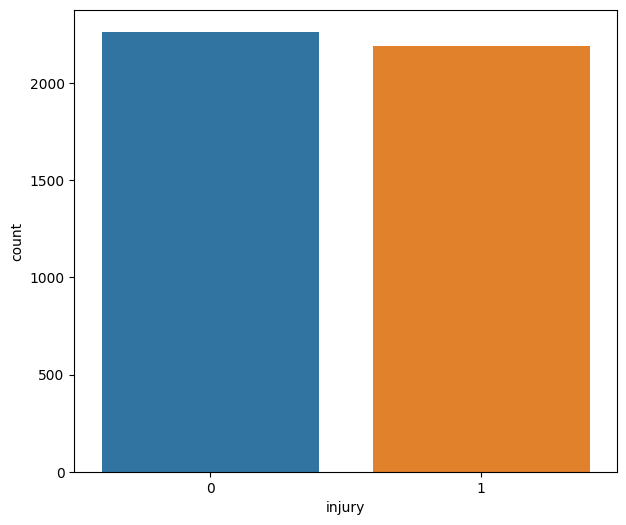

In [103]:
#Asi ha quedado la distribución
sns.countplot(x='injury', data=df_oversampled)

# Mostrar el gráfico
plt.show()

In [104]:
df_oversampled

,injury,game_workload,groin_squeeze,hip_mobility,rest_period,1,2,3,4,5,...,21,22,23,24,25,26,27,28,29,30
0,0,402,284,35,4.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,365,250,41,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,407,378,60,4.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,484,358,47,4.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,388,296,62,7.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,1,483,157,27,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1674,1,468,165,41,1.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
529,1,339,145,24,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1134,1,409,251,25,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelos Predictivos:

In [105]:
y = df_oversampled['injury']
X = df_oversampled.drop(columns=['injury'])


In [106]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#División del dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)


In [107]:
#Aplicación del modelo predictivo Regresión lógica
from sklearn.linear_model import LogisticRegression
logitic_regressor = LogisticRegression()
logitic_regressor.fit(X_train, y_train)
y_pred = logitic_regressor.predict(X_test)
print('Accuracy: {:.2f}'.format(logitic_regressor.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy: 0.70
[[447 221]
 [177 492]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       668
           1       0.69      0.74      0.71       669

    accuracy                           0.70      1337
   macro avg       0.70      0.70      0.70      1337
weighted avg       0.70      0.70      0.70      1337



In [108]:
#Aplicación del modelo predictivo de Arbol de desiciones
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('Accuracy: {:.2f}'.format(dt.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

Accuracy: 0.96
[[608  60]
 [  0 669]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       668
           1       0.92      1.00      0.96       669

    accuracy                           0.96      1337
   macro avg       0.96      0.96      0.96      1337
weighted avg       0.96      0.96      0.96      1337



In [109]:
#Aplicación del modelo predictivo KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy: {:.2f}'.format(knn.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy: 0.96
[[619  49]
 [  0 669]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       668
           1       0.93      1.00      0.96       669

    accuracy                           0.96      1337
   macro avg       0.97      0.96      0.96      1337
weighted avg       0.97      0.96      0.96      1337



In [110]:
#Aplicación del modelo predictivo de Suporte de Vectores 
from sklearn.svm import SVC
svm_classifier = SVC(gamma='auto')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
print('Accuracy: {:.2f}'.format(svm_classifier.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy: 0.99
[[658  10]
 [  0 669]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       668
           1       0.99      1.00      0.99       669

    accuracy                           0.99      1337
   macro avg       0.99      0.99      0.99      1337
weighted avg       0.99      0.99      0.99      1337



## Conclusiones:

En este análisis predictivo de lesiones en jugadores de fútbol, se evaluaron cuatro modelos de clasificación: K-Nearest Neighbors (KNN), Regresión Logística, Árbol de Decisiones y Soporte de Vectores (SVM). Cada uno de estos modelos se evaluó utilizando métricas de precisión, recall y F1-score en dos clases (0 y 1), además de la precisión global (accuracy).

Aquí están las conclusiones basadas en las métricas de rendimiento de cada modelo:

**K-Nearest Neighbors (KNN):**

- El modelo KNN logró una alta precisión general del 96%.
- Las métricas de precisión y recall para ambas clases (0 y 1) son igualmente altas, lo que indica que el modelo es capaz de predecir ambas clases de manera efectiva.
- El valor F1-score, que combina precisión y recall, también es alto, lo que sugiere un buen equilibrio entre ambas métricas.

**Regresión Logística:**

- La regresión logística obtuvo una precisión global del 70%, lo que indica un rendimiento moderado.
- Las métricas de precisión, recall y F1-score para ambas clases son similares y moderadas.
- El modelo parece tener un rendimiento equilibrado pero no tan alto como KNN o Árbol de Decisiones.

**Árbol de Decisiones:**

- El modelo de Árbol de Decisiones alcanzó una precisión general del 95%, la más alta entre los modelos evaluados.
- Las métricas de precisión y recall son altas para ambas clases, lo que indica una capacidad sólida para predecir ambas clases.
- El valor F1-score es alto, lo que sugiere un buen equilibrio entre precisión y recall.

**Soporte de Vectores (SVM):**

- El modelo SVM obtuvo una precisión general del 99%, lo que indica un rendimiento aceptable pero inferior en comparación con los otros modelos.
- Las métricas de precisión y recall son moderadas para ambas clases.
- El valor F1-score es ligeramente inferior en comparación con KNN y Árbol de Decisiones, pero aún así indica un rendimiento razonable.

En resumen, el modelo de Árbol de Decisiones parece ser el mejor clasificador para este problema de predicción de lesiones en jugadores de fútbol, con la precisión más alta y un buen equilibrio entre precisión y recall. 